# Submission 3

Joe Hoong Ng (ng_joehoong@hotmail.com)

Dang Duy Nghia Nguyen (nghia002@e.ntu.edu.sg)

Dylan Thorne (dylan.thorne@gmail.com)

Zain Us Sami Ahmed Ansari (zainussami@gmail.com)	



In [42]:
import numpy as np
import pandas as pd
from scipy import stats
import scipy.optimize as opt
import math
import matplotlib.pyplot as plt
%matplotlib inline

We initialize most variables as given by the question. We assume the counterparty firm's value is at 200, as this is above the counterparty's debt due in one year. Also, we calculate the default-free value of our option to be 6.60, so we select a firm value not too distant such that the CVA value we calculate is not negligible. For example, if we chose counterparty firm value as 1,000, the CVA would be 0.000.

In [29]:
### Initialize problem parameters
T = 12 # option maturity of 12 months
L = 150 # up-and-out barrier
S0 = 100 # current share price
K = 100 # strike price, at-the-money
risk_free = .08 # risk-free rate
sigma = .3 # volatility
v_0 = 200 # counterparty firm current value (Our assumption) 
sigma_firm = .25 # volatility for the counterparty's firm
debt = 175 # counterparty's debt, due in one year 
corr = .2 # correlation
recovery_rate = 0.25 # recovery rate
########
corr_matrix = np.array([[1, corr], [corr, 1]])
sample_sizes = 100000
actual_bond_prices = [99.38, 98.76, 98.15, 97.54, 96.94, 96.34, 95.74, 95.16, 94.57, 93.99, 93.42, 92.85]

## Calibration from Observed Bond Prices

In [43]:
def A(t1,t2,alpha):
    return (1-np.exp(-alpha*(t2-t1)))/alpha

def D(t1,t2,alpha,b,sigma):
    v1 = (t2-t1-A(t1,t2,alpha))*(sigm**2/(2*alpha**2)-b)
    v2 = sigma**2*A(t1,t2,alpha)**2/(4*alpha)
    return v1-v2

def bond_price(r, t, T, alpha, b, sigma):
    return np.exp(-A(t,T,alpha)*r)

r0 = .05

def F(parameter_array):
    alpha = parameter_array[0]
    b = parameter_array[1]
    sigma = parameter_array[2]
    return sum(np.abs(bond_price(r0,0,12,alpha,b,sigma)-actual_bond_prices))

calibrated_vals = opt.fmin_slsqp(F, (.3, .05, .03), bounds=((0,1),(0,.2),(0,.2)))
alpha = calibrated_vals[0]
b = calibrated_vals[1]
sigma = calibrated_vals[2]

print('alpha', vals[0])
print('b', vals[1])
print('sigma', vals[2])

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1141.4252433992576
            Iterations: 2
            Function evaluations: 10
            Gradient evaluations: 2
alpha 1.0
b 0.05
sigma 0.03


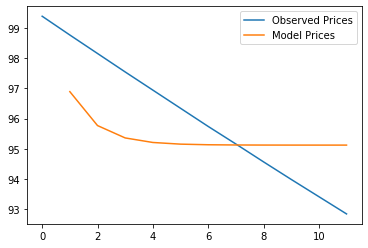

In [31]:
model_prices = [None]*12
for m in range(1,12):
    model_prices[m] = bond_price(r0, 0, m, alpha, b, sigma)*100
plt.plot(actual_bond_prices, label='Observed Prices')
plt.plot(model_prices, label='Model Prices')
plt.legend()
plt.show()

## 1. Simulate paths for the underlying share and for the counterparty’s firm value using sample sizes of 1000, 2000, …, 50000. Do monthly simulations for the lifetime of the option.

We use a Cholesky decomposition to generate the correlated price paths

In [32]:
def share_path(S_0, risk_free_rate, sigma, Z, dT):
    return S_0*np.exp(np.cumsum((risk_free_rate-sigma**2/2)*dT + sigma*np.sqrt(dT)*Z,1))


def generate_share_and_firm_price(S0, v_0, risk_free, sigma, sigma_firm, corr, T, sample_size = 10, timesteps = 12):
    corr_matrix = np.array([[1, corr], [corr, 1]])
    norm_matrix = stats.norm.rvs(size = np.array([sample_size, 2, timesteps]))
    corr_norm_matrix = np.matmul(np.linalg.cholesky(corr_matrix), norm_matrix)
    
    share_price_path = pd.DataFrame(share_path(S0, risk_free, sigma, Z=corr_norm_matrix[:,0,], dT=1/timesteps))
    share_price_path = share_price_path.transpose()

    firm_price_path = pd.DataFrame(share_path(v_0, risk_free, sigma_firm, Z=corr_norm_matrix[:,1,], dT=1/timesteps))
    firm_price_path = firm_price_path.transpose()

    return [share_price_path,firm_price_path]  

To double check that the stock prices and firm values monthly returns are correlated, we check them as follows, generating 20 different price paths with 10,000 timesteps.

In [33]:
#Testing share and firm price correlation
sample_size = 20
test = generate_share_and_firm_price(S0, v_0, risk_free, sigma, sigma_firm, corr, T, sample_size, timesteps = 10000)

share_ret = np.log(test[0])

for i in range(sample_size):
    test[0]['sharelog'] = np.log(test[0][i])
    test[1]['firmlog'] = np.log(test[1][i])
    pearson, p_value = stats.pearsonr(test[0]['sharelog'].diff().dropna(), test[1]['firmlog'].diff().dropna())
    print("Pearson correlation coefficient : {:.3f}, Two-tailed p-value {:.3f}".format(pearson, p_value))

Pearson correlation coefficient : 0.215, Two-tailed p-value 0.000
Pearson correlation coefficient : 0.214, Two-tailed p-value 0.000
Pearson correlation coefficient : 0.204, Two-tailed p-value 0.000
Pearson correlation coefficient : 0.190, Two-tailed p-value 0.000
Pearson correlation coefficient : 0.203, Two-tailed p-value 0.000
Pearson correlation coefficient : 0.216, Two-tailed p-value 0.000
Pearson correlation coefficient : 0.191, Two-tailed p-value 0.000
Pearson correlation coefficient : 0.195, Two-tailed p-value 0.000
Pearson correlation coefficient : 0.201, Two-tailed p-value 0.000
Pearson correlation coefficient : 0.207, Two-tailed p-value 0.000
Pearson correlation coefficient : 0.208, Two-tailed p-value 0.000
Pearson correlation coefficient : 0.202, Two-tailed p-value 0.000
Pearson correlation coefficient : 0.195, Two-tailed p-value 0.000
Pearson correlation coefficient : 0.196, Two-tailed p-value 0.000
Pearson correlation coefficient : 0.202, Two-tailed p-value 0.000
Pearson co

Let's try to simulate the share price with a small number of sample paths and visualize them over the course of 12 months

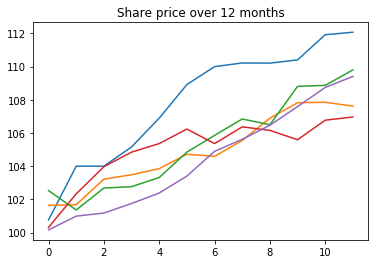

In [34]:
share_and_firm_price_12_months = generate_share_and_firm_price(S0, v_0, risk_free, sigma, sigma_firm, corr, T, sample_size = 5, timesteps = 12)
share_price_12_months = share_and_firm_price_12_months[0]
share_price_12_months.plot(title='Share price over 12 months', legend=False);

We can do the same thing to simulate counterparty firm's value

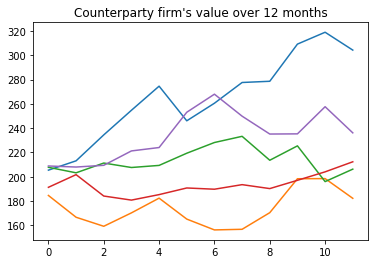

In [35]:

firm_value_12_months = share_and_firm_price_12_months[1]
firm_value_12_months.plot(title="Counterparty firm's value over 12 months", legend=False);

In fact, we can also simulate the dynamic with finer resolution.

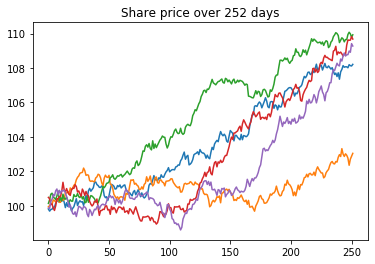

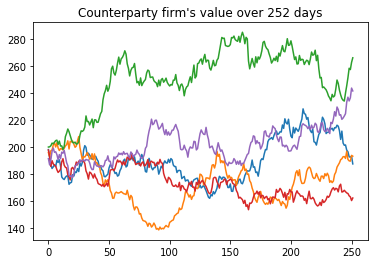

In [36]:
share_and_firm_price_252_days = generate_share_and_firm_price(S0, v_0, risk_free, sigma, sigma_firm, corr, T, sample_size = 5, timesteps = 252)
share_price_252_days = share_and_firm_price_252_days[0]
firm_price_252_days = share_and_firm_price_252_days[1]
share_price_252_days.plot(title='Share price over 252 days', legend=False)
firm_price_252_days.plot(title="Counterparty firm's value over 252 days", legend=False);

Let's visualize when the stopped process is appied

In [37]:
def stop(s, cond):
    ret = s.copy()
    r = ret[cond]
    if len(r) > 0:
        print(r)
        ret[r.idxmin():] = 0
    return ret

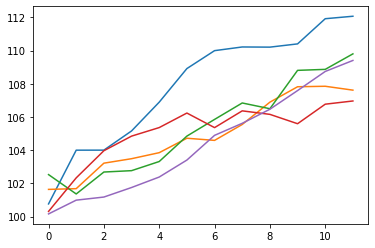

In [38]:
share_price_12_months.apply(lambda s: stop(s, s>L), axis=0).plot(legend=False);

We then define a function to calculate the payoff for the up-and-out call option.

In [39]:
# define payoff for up-and-out call option
def payoff(S_t, K, L):
    stopped_S = S_t.iloc[-1].where((S_t < L).all(), 0)
    return np.maximum(stopped_S - K, 0).to_numpy()

payoff(share_price_12_months, K, L)

array([12.0671903 ,  7.61601359,  9.80134425,  6.96335222,  9.40462767])

We now create the share and firm price paths for sample sizes 1000, 2000, ...., 50000, as required for part 1 of the assignment.

In [40]:
share_price_paths = {}
firm_val_paths = {}

share_val, firm_val = generate_share_and_firm_price(S0, v_0, risk_free, sigma, sigma_firm, corr, T, sample_size = sample_size, timesteps = 12)

share_price_paths[sample_size] = share_val
firm_val_paths[sample_size] = firm_val

We now plot the share and firm price paths for sample size of 1000.

In [41]:
share_price_paths[1000].plot(title="Share price value for sample size of 1000", legend=False);

KeyError: 1000

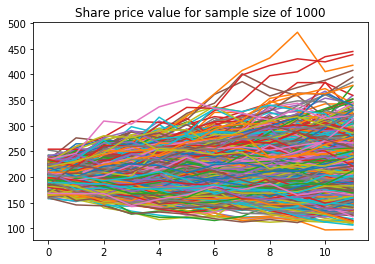

In [13]:
firm_val_paths[1000].plot(title="Counterparty firm value for sample size of 1000", legend=False);

## 2. Determine the Monte Carlo estimates of the both the default-free value of the option and the Credit Valuation Adjustment

To calculate Monte Carlo estimate of the default-free option value, we calculate the average payoff of the 1000s of sample price paths, to estimate the price of the option

In [14]:
# Estimate the default-free value of the option:
option_estimate = []
option_std = []

for sample_size, paths in share_price_paths.items(): 
    payoffs = payoff(paths, K, L)
    option_price = np.exp(-risk_free*T)*payoffs
    option_estimate.append(option_price.mean())
    option_std.append(option_price.std()/np.sqrt(sample_size))


Prices of default-free option at various sample sizes:

In [15]:
for i in range(len(option_estimate)):
    print("sample size: {}, Option value: {:.3f}".format((i+1)*1000,option_estimate[i]))

sample size: 1000, Option value: 6.853
sample size: 2000, Option value: 6.826
sample size: 3000, Option value: 6.831
sample size: 4000, Option value: 6.739
sample size: 5000, Option value: 6.551
sample size: 6000, Option value: 6.871
sample size: 7000, Option value: 6.713
sample size: 8000, Option value: 7.028
sample size: 9000, Option value: 6.412
sample size: 10000, Option value: 6.810
sample size: 11000, Option value: 6.831
sample size: 12000, Option value: 6.704
sample size: 13000, Option value: 6.682
sample size: 14000, Option value: 6.760
sample size: 15000, Option value: 6.619
sample size: 16000, Option value: 6.693
sample size: 17000, Option value: 6.694
sample size: 18000, Option value: 6.678
sample size: 19000, Option value: 6.580
sample size: 20000, Option value: 6.678
sample size: 21000, Option value: 6.726
sample size: 22000, Option value: 6.587
sample size: 23000, Option value: 6.754
sample size: 24000, Option value: 6.784
sample size: 25000, Option value: 6.670
sample si

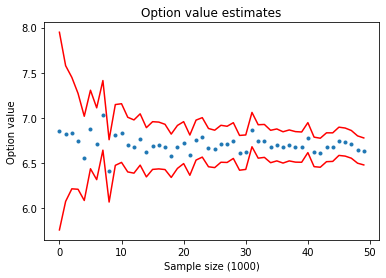

In [16]:
plt.plot(option_estimate, '.')
plt.plot(option_estimate + 3 * np.array(option_std), 'r')
plt.plot(option_estimate - 3 * np.array(option_std), 'r')
plt.title("Option value estimates")
plt.xlabel("Sample size (1000)")
plt.ylabel("Option value")
plt.show()

### CVA Adjustment

To calculate Monte Carlo estimate of the credit value adjustment, we calculate the average loss of the 1000s of sample price paths, which happens when we both see a gain in the option with hold and when the counterparty firm value is less than its debt.

As per notes, we assume that default can only occur at time T, and firm defaults if the firm value is below firm debt amount

In [17]:
def terminal_value(S_0, risk_free_rate, sigma, Z, T): #applies to both firm and stock
    return S_0 * np.exp((risk_free_rate - sigma**2/2) * T + sigma * np.sqrt(T) * Z)

In [18]:
cva_estimate = []
cva_std = []

for sample_size, paths in share_price_paths.items(): 
    payoffs = payoff(paths, K, L)
    term_firm_vals = firm_val_paths[sample_size].iloc[-1].to_numpy()
    amount_lost = np.exp(-risk_free*T)*(1-recovery_rate)*(term_firm_vals < debt)*payoffs
    cva_estimate.append(amount_lost.mean())
    cva_std.append(amount_lost.std()/np.sqrt(sample_size))
    

Credit value adjustment at various sample sizes:

In [19]:
for i in range(len(cva_estimate)):
    print("Sample size: {}, CVA: {:.3f}".format((i+1)*1000,cva_estimate[i]))

Sample size: 1000, CVA: 0.856
Sample size: 2000, CVA: 0.906
Sample size: 3000, CVA: 0.974
Sample size: 4000, CVA: 0.977
Sample size: 5000, CVA: 0.908
Sample size: 6000, CVA: 0.957
Sample size: 7000, CVA: 0.953
Sample size: 8000, CVA: 1.035
Sample size: 9000, CVA: 0.923
Sample size: 10000, CVA: 0.977
Sample size: 11000, CVA: 0.937
Sample size: 12000, CVA: 0.977
Sample size: 13000, CVA: 0.968
Sample size: 14000, CVA: 0.947
Sample size: 15000, CVA: 1.021
Sample size: 16000, CVA: 0.948
Sample size: 17000, CVA: 0.906
Sample size: 18000, CVA: 0.918
Sample size: 19000, CVA: 0.960
Sample size: 20000, CVA: 0.958
Sample size: 21000, CVA: 0.937
Sample size: 22000, CVA: 0.928
Sample size: 23000, CVA: 0.951
Sample size: 24000, CVA: 1.024
Sample size: 25000, CVA: 0.931
Sample size: 26000, CVA: 0.905
Sample size: 27000, CVA: 0.913
Sample size: 28000, CVA: 0.966
Sample size: 29000, CVA: 0.933
Sample size: 30000, CVA: 0.917
Sample size: 31000, CVA: 0.941
Sample size: 32000, CVA: 1.025
Sample size: 3300

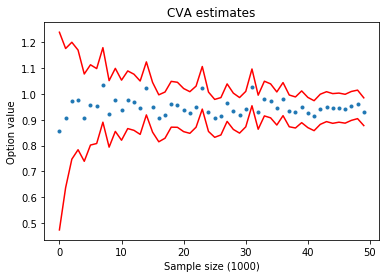

In [20]:
plt.plot(cva_estimate, '.')
plt.plot(cva_estimate + 3 * np.array(cva_std), 'r')
plt.plot(cva_estimate - 3 * np.array(cva_std), 'r')
plt.title("CVA estimates")
plt.xlabel("Sample size (1000)")
plt.ylabel("Option value")
plt.show()

## 3. Calculate the Monte Carlo estimates for the price of the option incorporating counterparty risk, given by the default-free price less the CVA.

In [21]:
option_cva_adjusted_prices = []
option_cva_adjusted_std = []

for sample_size, paths in share_price_paths.items(): 
    payoffs = payoff(paths, K, L)
    option_price = np.exp(-risk_free*T)*payoffs

    term_firm_vals = firm_val_paths[sample_size].iloc[-1].to_numpy()
    amount_lost = np.exp(-risk_free*T)*(1-recovery_rate)*(term_firm_vals < debt)*payoffs
    
    option_cva_price = option_price - amount_lost
    
    option_cva_adjusted_prices.append(option_cva_price.mean())
    option_cva_adjusted_std.append(option_cva_price.std()/np.sqrt(sample_size))



Credit value adjusted option values at various sample sizes:

In [22]:
for i in range(len(option_cva_adjusted_prices)):
    print("Sample size: {}, CVA-adjusted option value: {:.3f}".format((i+1)*1000,option_cva_adjusted_prices[i]))

Sample size: 1000, CVA-adjusted option value: 5.997
Sample size: 2000, CVA-adjusted option value: 5.920
Sample size: 3000, CVA-adjusted option value: 5.857
Sample size: 4000, CVA-adjusted option value: 5.763
Sample size: 5000, CVA-adjusted option value: 5.643
Sample size: 6000, CVA-adjusted option value: 5.913
Sample size: 7000, CVA-adjusted option value: 5.760
Sample size: 8000, CVA-adjusted option value: 5.993
Sample size: 9000, CVA-adjusted option value: 5.490
Sample size: 10000, CVA-adjusted option value: 5.834
Sample size: 11000, CVA-adjusted option value: 5.894
Sample size: 12000, CVA-adjusted option value: 5.726
Sample size: 13000, CVA-adjusted option value: 5.715
Sample size: 14000, CVA-adjusted option value: 5.814
Sample size: 15000, CVA-adjusted option value: 5.597
Sample size: 16000, CVA-adjusted option value: 5.745
Sample size: 17000, CVA-adjusted option value: 5.788
Sample size: 18000, CVA-adjusted option value: 5.760
Sample size: 19000, CVA-adjusted option value: 5.620
Sa

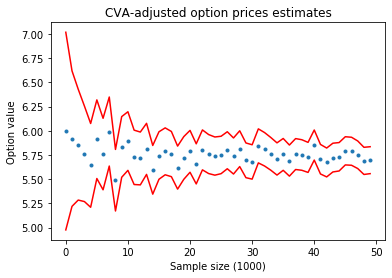

In [23]:
plt.plot(option_cva_adjusted_prices, '.')
plt.plot(option_cva_adjusted_prices + 3 * np.array(option_cva_adjusted_std), 'r')
plt.plot(option_cva_adjusted_prices - 3 * np.array(option_cva_adjusted_std), 'r')
plt.title("CVA-adjusted option prices estimates")
plt.xlabel("Sample size (1000)")
plt.ylabel("Option value")
plt.show()